In [1194]:
import pandas as pd
import geopandas as gpd
import tensorflow as tf
# import teller as tr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import missingno as msno
# import pyarrow as pa
# import pyarrow.parquet as pq
import numpy as np



In [1195]:
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno

In [1196]:

path = './nowa_gwiazdka_wiecej_kolumn_in.geojson'
df_p = gpd.read_file(path)


<Axes: >

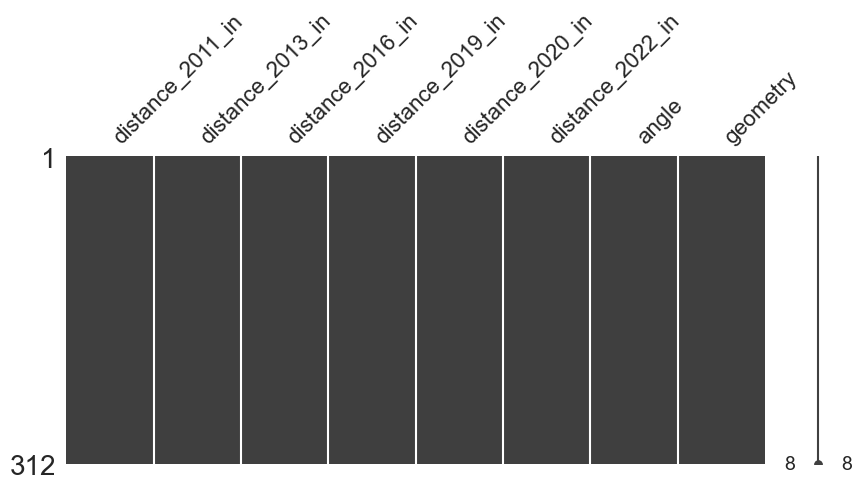

In [1197]:
msno.matrix(df_p, figsize=(10,4)) # test pustych wierszy
# df_p =df_p.fillna(0) # wypełnianie Nan zerami


In [1198]:
df_p.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance_2011_in,312.0,138.506393,44.380452,78.318949,109.880161,129.201749,163.666901,282.922344
distance_2013_in,312.0,139.863228,44.916568,79.933218,111.606029,128.666297,166.953484,287.252755
distance_2016_in,312.0,159.085973,38.580670,111.448661,130.167464,149.836502,182.365937,296.978123
distance_2019_in,312.0,161.845580,36.599845,119.220908,133.953702,152.388184,183.325978,291.848589
distance_2020_in,312.0,162.590803,36.695019,119.732925,134.442917,152.887354,183.463170,287.835551
distance_2022_in,312.0,166.922885,37.461780,118.977710,136.889883,158.007758,192.407383,293.873336
angle,312.0,186.500000,90.210864,31.000000,108.750000,186.500000,264.250000,342.000000


In [1199]:
df_p.head()

,distance_2011_in,distance_2013_in,distance_2016_in,distance_2019_in,distance_2020_in,distance_2022_in,angle,geometry
0,282.922344,287.252755,296.978123,291.848589,287.835551,293.873336,31,"LINESTRING (7527541.11000 5863838.87000, 75276..."
1,276.152936,280.594065,290.187170,283.331593,282.456345,286.524895,32,"LINESTRING (7527541.11000 5863838.87000, 75277..."
2,269.513770,274.713088,283.639434,278.221612,278.251581,281.598240,33,"LINESTRING (7527541.11000 5863838.87000, 75277..."
3,264.506379,268.604808,277.313791,273.528959,272.132216,276.107512,34,"LINESTRING (7527541.11000 5863838.87000, 75277..."
4,262.003752,264.087092,271.244684,268.361456,267.252805,270.845841,35,"LINESTRING (7527541.11000 5863838.87000, 75277..."


In [1200]:
df_p.shape


(312, 8)

In [1201]:
#normalizacja i podzial na dane wejsciowe i wyjsciowe
X = df_p[["distance_2011_in", "distance_2013_in","distance_2016_in", "distance_2019_in", "distance_2020_in", "angle"]]
X = MinMaxScaler().fit_transform(X)
y = df_p["distance_2022_in"]
X.shape, y.shape

((312, 6), (312,))

In [1202]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     # random_state=42,
                                                     test_size=.4)

In [1203]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((187, 6), (125, 6), (187,), (125,))

# MODEL

In [1204]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate,Dropout,CategoryEncoding, Embedding, Flatten,Conv2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.random import set_seed #ustawiam ziarno pseudolosowości
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime as dt
import os

In [1205]:
N_TRAIN = int(1e4)
BATCH_SIZE = 4
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

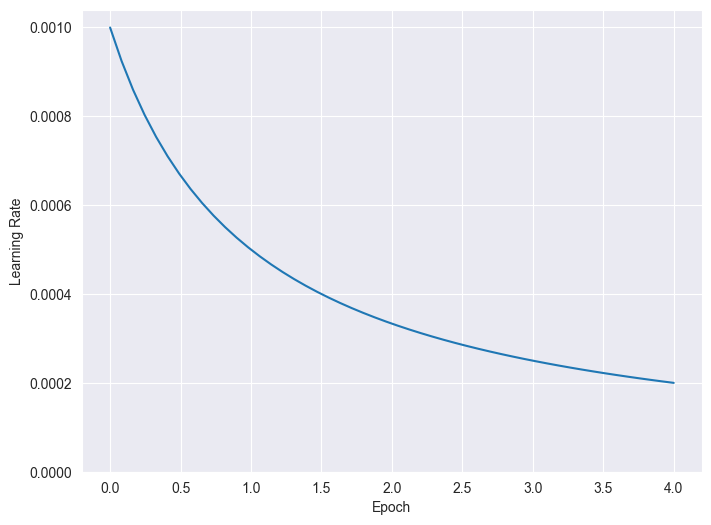

In [1206]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [1207]:
from keras import regularizers


def create_ANN():
    set_seed(0)
    model = Sequential()
    model.add(
        Dense(5, activation='relu',
              kernel_regularizer=regularizers.l2(0.001), #opcja
              kernel_initializer='he_uniform')
    )
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(
        Dense(1, activation='relu',
              kernel_regularizer=regularizers.l2(0.001))# opcja
    )

    model.compile(
        loss='mse',
        optimizer=get_optimizer(),
        metrics=['mae','mse'])

    return model

In [1208]:
_filepath = 'checkpoint/ann-{epoch:02d}-{loss:.3f}.h5' # for filepath
checkpoint = ModelCheckpoint(monitor='loss', filepath='checkpoint/_best-ann.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', patience=3, min_delta=0.01, verbose=1)
tb = TensorBoard(log_dir='logs/'+dt.now().strftime("%Y%m%d-%H%M%S")) # logi tensor board

In [1209]:
model = create_ANN()

result = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    validation_split=.3,
    callbacks=[checkpoint,es,tb],
    verbose=0,
)


Epoch 1: loss improved from inf to 28713.25000, saving model to checkpoint\_best-ann.h5


C:\Users\patry\Desktop\ai_river_project\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 28713.25000 to 28655.41992, saving model to checkpoint\_best-ann.h5

Epoch 3: loss improved from 28655.41992 to 28573.36328, saving model to checkpoint\_best-ann.h5

Epoch 4: loss improved from 28573.36328 to 28432.36523, saving model to checkpoint\_best-ann.h5

Epoch 5: loss improved from 28432.36523 to 28175.22852, saving model to checkpoint\_best-ann.h5

Epoch 6: loss improved from 28175.22852 to 27704.59961, saving model to checkpoint\_best-ann.h5

Epoch 7: loss improved from 27704.59961 to 26903.20898, saving model to checkpoint\_best-ann.h5

Epoch 8: loss improved from 26903.20898 to 25552.70898, saving model to checkpoint\_best-ann.h5

Epoch 9: loss improved from 25552.70898 to 23092.68750, saving model to checkpoint\_best-ann.h5

Epoch 10: loss improved from 23092.68750 to 19919.61523, saving model to checkpoint\_best-ann.h5

Epoch 11: loss improved from 19919.61523 to 15305.37207, saving model to checkpoint\_best-ann.h5

Epoch 12: loss improved fro

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_206 (Dense)           (None, 5)                 35        
                                                                 
 dropout_46 (Dropout)        (None, 5)                 0         
                                                                 
 dense_207 (Dense)           (None, 8)                 48        
                                                                 
 dense_208 (Dense)           (None, 5)                 45        
                                                                 
 dense_209 (Dense)           (None, 7)                 42        
                                                                 
 dense_210 (Dense)           (None, 1)                 8         
                                                                 
Total params: 178 (712.00 Byte)
Trainable params: 178

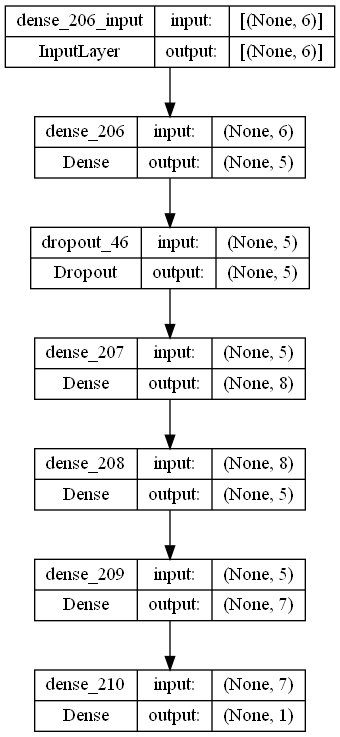

In [1210]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1211]:
# evaluate the keras model
loss,  mae , mse = model.evaluate(X_test, y_test)
print(f'loss:{loss}, \nmse: {mse}')

4/4 [==============================] - 0s 4ms/step - loss: 1398.4955 - mae: 31.3276 - mse: 1398.4817
loss:1398.4954833984375, 
mse: 1398.481689453125


Text(0.5, 0, 'Epoka')

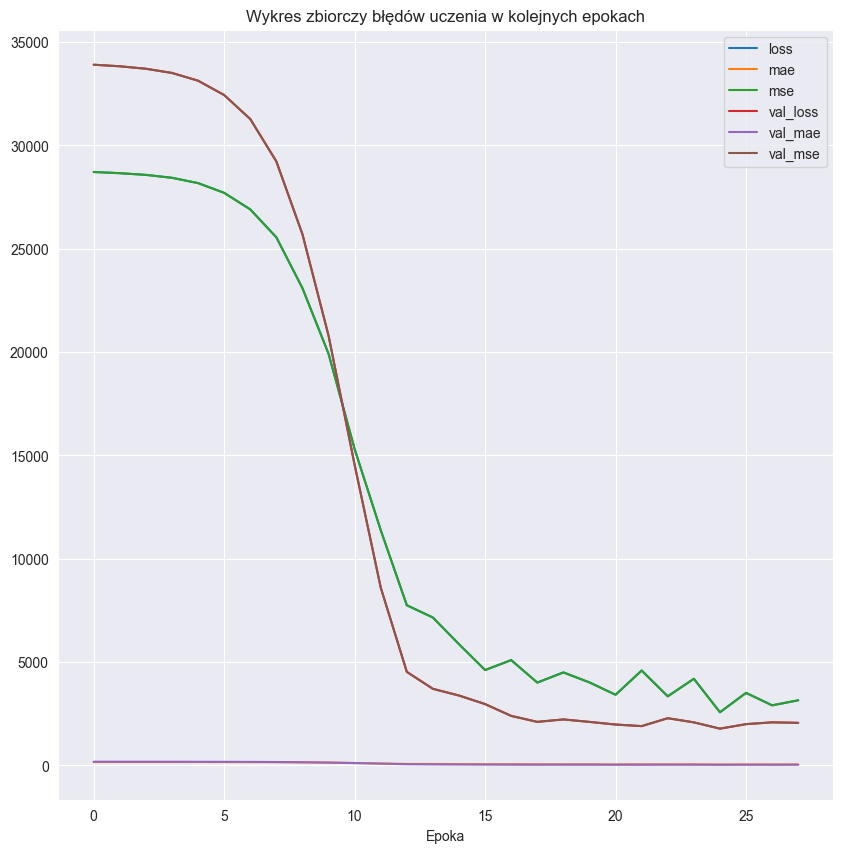

In [1212]:
df_results = pd.DataFrame(result.history)
df_results.plot(figsize=(10,10))
plt.title('Wykres zbiorczy błędów uczenia w kolejnych epokach')
plt.xlabel('Epoka')

In [1213]:
df_results

,loss,mae,mse,val_loss,val_mae,val_mse
0,28713.250000,165.489502,28713.240234,33903.562500,178.364548,33903.554688
1,28655.419922,165.310776,28655.410156,33828.062500,178.154175,33828.058594
2,28573.363281,165.075378,28573.355469,33707.976562,177.825623,33707.964844
3,28432.365234,164.644592,28432.359375,33505.980469,177.273010,33505.972656
4,28175.228516,163.865662,28175.222656,33130.859375,176.244812,33130.851562
5,27704.599609,162.451431,27704.589844,32436.191406,174.332504,32436.185547
6,26903.208984,160.131607,26903.191406,31274.628906,171.097198,31274.617188
7,25552.708984,155.924057,25552.699219,29224.333984,165.209290,29224.318359
8,23092.687500,147.982315,23092.671875,25701.228516,154.632065,25701.216797
9,19919.615234,136.201309,19919.605469,20794.986328,138.530228,20794.976562


In [1214]:
y_predicted = model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


In [1215]:
df__a = pd.DataFrame(y_test)
df__a['y_predicted']=y_predicted
df__a['diff']=df__a.y_predicted-df__a.distance_2022_in
df__a['abs_diff'] = abs(df__a['diff'])
df__a['diff_pow']=df__a['diff']*df__a['diff']
df__a.tail()

,distance_2022_in,y_predicted,diff,abs_diff,diff_pow
104,136.885100,107.771797,-29.113303,29.113303,847.584423
46,165.117518,116.065819,-49.051699,49.051699,2406.069150
182,192.679712,148.622559,-44.057153,44.057153,1941.032741
66,145.699743,110.395821,-35.303922,35.303922,1246.366907
88,133.278800,108.580086,-24.698714,24.698714,610.026487


In [1216]:
import math
mean_ref = df__a['distance_2022_in'].describe()[1]
bias = df__a['diff'].describe()[1]
mae =df__a['abs_diff'].describe()[1]
RMSE = math.sqrt(df__a['diff_pow'].sum()/df__a.shape[0])
print(
    f'mean_ref: {mean_ref},'
    f'\nbias: {bias}, \nbias_%: {bias/mean_ref*100}, '
    f'\nmae: {mae}, \nmae_%: {mae/mean_ref*100}, '
    f'\nRMSE: {RMSE} \nRMSE %: {RMSE/mean_ref*100}'
)

mean_ref: 163.01694948802003,
bias: -30.29627724680907, 
bias_%: -18.58474063093391, 
mae: 31.32759780924329, 
mae_%: 19.21738684697049, 
RMSE: 37.396280265674015 
RMSE %: 22.940117811750753


C:\Users\patry\AppData\Local\Temp\ipykernel_13064\3754689643.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_ref = df__a['distance_2022_in'].describe()[1]
C:\Users\patry\AppData\Local\Temp\ipykernel_13064\3754689643.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bias = df__a['diff'].describe()[1]
C:\Users\patry\AppData\Local\Temp\ipykernel_13064\3754689643.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mae =df__a[

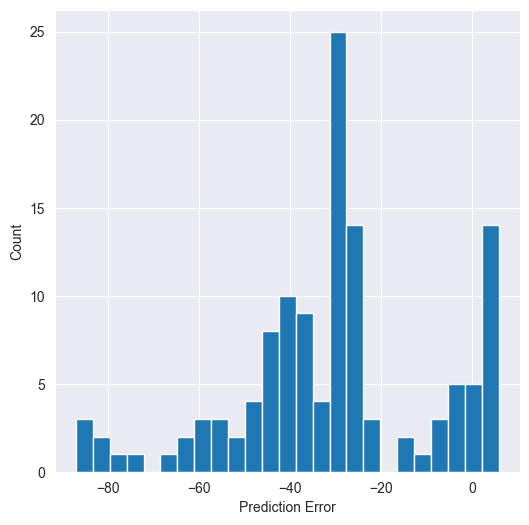

In [1217]:
# rozkład błedów
error = df__a.y_predicted-df__a.distance_2022_in
plt.figure(figsize = (6,6))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

<Figure size 800x800 with 0 Axes>

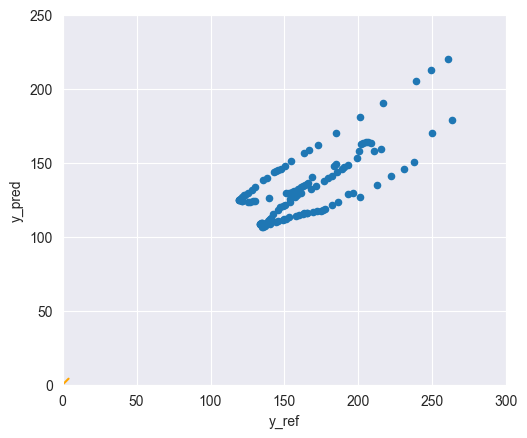

In [1218]:
plt.figure(figsize = (8,8))
df__a.plot.scatter(y='y_predicted', x='distance_2022_in')
plt.plot(range(5), color='orange')
plt.xlim(0, 300)
plt.ylim(0, 250)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('y_ref')
plt.ylabel('y_pred')
plt.draw()